In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [24]:
# Standard Python libraries for data manipulation and regular expressions
import re
import string

# Data analysis and visualization libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# PySpark related imports for Spark session and data frame operations
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, regexp_extract, udf, count, when, sum, to_date, date_format, monotonically_increasing_id
)
from pyspark.sql.types import StringType, FloatType

# NLTK for natural language processing tasks
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# TextBlob for sentiment analysis
from textblob import TextBlob

#### Initializing Spark Session

In [3]:
spark = SparkSession.builder \
                    .appName("Tweets Pre-process") \
                    .getOrCreate()

#### Database Connection Setup

In [4]:
# Database connection parameters
database_url = "jdbc:mysql://localhost:3306/tweets_data"
properties = {
    "user": "root",
    "password": "password",  
    "driver": "com.mysql.cj.jdbc.Driver"
}

# Reading data from the 'tweets' table into a DataFrame
df = spark.read.jdbc(url=database_url, table="tweets", properties=properties)

#### Data Preview

In [5]:
# Display the first five rows of the DataFrame for a preliminary inspection
df.show(5)

+---+--------------------+---------------+--------------------+
|IDs|                Date|           user|                text|
+---+--------------------+---------------+--------------------+
|  1|Mon Apr 06 22:19:...|_TheSpecialOne_|@switchfoot http:...|
|  2|Mon Apr 06 22:19:...|  scotthamilton|is upset that he ...|
|  3|Mon Apr 06 22:19:...|       mattycus|@Kenichan I dived...|
|  4|Mon Apr 06 22:19:...|        ElleCTF|my whole body fee...|
|  5|Mon Apr 06 22:19:...|         Karoli|@nationwideclass ...|
+---+--------------------+---------------+--------------------+
only showing top 5 rows



In [6]:
# Count the number of rows in the DataFrame to understand the size of the dataset
dataset_size = df.count()
print("Dataset Size:", dataset_size)

Dataset Size: 1598315


In [7]:
# Print the schema of the DataFrame to understand its structure
df.printSchema()

root
 |-- IDs: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [8]:
# Display the first 3 rows to inspect the format of the 'Date' column
df.head(3)

[Row(IDs=1, Date='Mon Apr 06 22:19:45 PDT 2009', user='_TheSpecialOne_', text="@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"),
 Row(IDs=2, Date='Mon Apr 06 22:19:49 PDT 2009', user='scotthamilton', text="is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"),
 Row(IDs=3, Date='Mon Apr 06 22:19:53 PDT 2009', user='mattycus', text='@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds')]

In [9]:
# Set Spark's time parser policy to legacy for compatibility with specific date formats
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [10]:
# Convert the 'Date' column to datetime format and then to 'YYYY-MM-DD' format
df = df.withColumn("Date", to_date(df["Date"], "E MMM dd HH:mm:ss zzz yyyy"))
df = df.withColumn("Date", date_format(df["Date"], "yyyy-MM-dd"))
df.show(5)

+---+----------+---------------+--------------------+
|IDs|      Date|           user|                text|
+---+----------+---------------+--------------------+
|  1|2009-04-07|_TheSpecialOne_|@switchfoot http:...|
|  2|2009-04-07|  scotthamilton|is upset that he ...|
|  3|2009-04-07|       mattycus|@Kenichan I dived...|
|  4|2009-04-07|        ElleCTF|my whole body fee...|
|  5|2009-04-07|         Karoli|@nationwideclass ...|
+---+----------+---------------+--------------------+
only showing top 5 rows



> *Note: A one-day shift in date values is observed due to timezone differences in the original data (PDT) and the processing environment. For sentiment analysis, particularly in forecasting trends, this minor shift is unlikely to significantly impact the overall analysis.*

#### Identifying the Time Range of the Dataset

In [11]:
from pyspark.sql import functions as F

# Calculate the maximum and minimum dates in the dataset
max_date = df.agg(F.max("Date")).collect()[0][0]
min_date = df.agg(F.min("Date")).collect()[0][0]

# Display the time range of the dataset
print("Maximum Date:", max_date)
print("Minimum Date:", min_date)

Maximum Date: 2009-06-25
Minimum Date: 2009-04-07


#### Analyzing User Activity for Suspicious Behavior

In [12]:
# Group by user and count the number of tweets, then order by count
user_distribution = df.groupBy("user").count().orderBy(F.desc("count"))
user_distribution.show()

+---------------+-----+
|           user|count|
+---------------+-----+
|       lost_dog|  549|
|        webwoke|  345|
|       tweetpet|  310|
|SallytheShizzle|  281|
|    VioletsCRUK|  279|
|    mcraddictal|  276|
|       tsarnick|  248|
|    what_bugs_u|  246|
|    Karen230683|  238|
|      DarkPiano|  236|
|   SongoftheOss|  227|
|      Jayme1988|  225|
|         keza34|  219|
| ramdomthoughts|  216|
|      shanajaca|  213|
|         wowlew|  212|
|     nuttychris|  211|
|   TraceyHewins|  211|
|   thisgoeshere|  207|
|     Spidersamm|  205|
+---------------+-----+
only showing top 20 rows



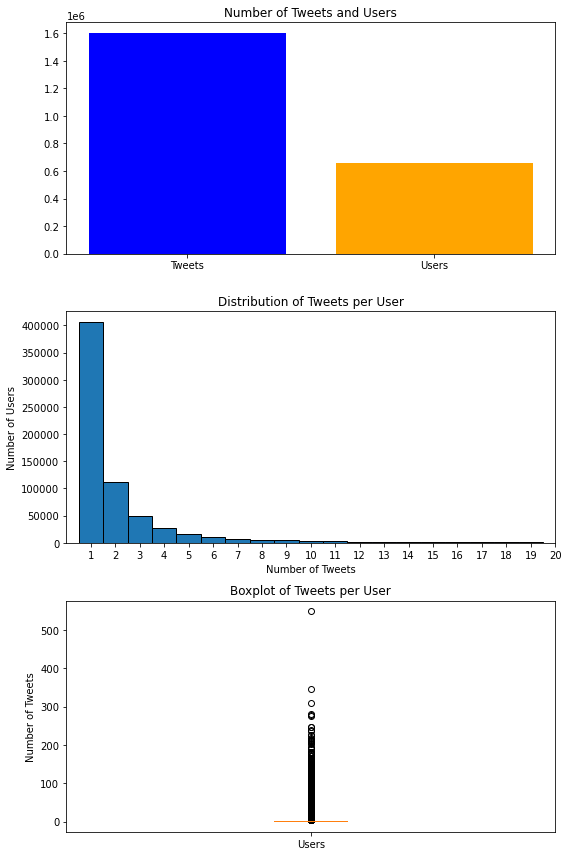

In [13]:
# Collect statistics for analysis
num_tweets = df.count()  # Count total tweets
num_users = df.select('user').distinct().count()  # Count unique users
tweets_per_user_pd = user_distribution.toPandas()  # Convert Spark DataFrame to Pandas DataFrame for plotting

# Set up a grid of subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Bar chart of number of tweets and users
axs[0].bar(["Tweets", "Users"], [num_tweets, num_users], color=['blue', 'orange'])
axs[0].set_title('Number of Tweets and Users')

# Histogram of tweets per user
axs[1].hist(tweets_per_user_pd['count'], bins=range(1, 21), edgecolor='black', align='left')
axs[1].set_title('Distribution of Tweets per User')
axs[1].set_xlabel('Number of Tweets')
axs[1].set_ylabel('Number of Users')
axs[1].set_xticks(range(1, 21))
axs[1].set_xlim(0, 20)

# Boxplot of tweets per user
axs[2].boxplot(tweets_per_user_pd['count'])
axs[2].set_title('Boxplot of Tweets per User')
axs[2].set_ylabel('Number of Tweets')
axs[2].set_xticklabels(['Users'])

plt.tight_layout()
plt.show()

### Insights from the Graphs

1. **Tweet-to-User Ratio:**
   - The dataset comprises approximately 1.598 million tweets from about 659,775 unique users, indicating an average of just over 2 tweets per user. This diverse user activity suggests a balanced mix of single and multiple tweets per user.

2. **Skewness in Tweet Distribution:**
   - The data shows a right-skewed distribution, with most users tweeting a few times, but a minority tweeting far more frequently than the average.

3. **Boxplot Analysis:**
   - The boxplot reveals that the median and interquartile range are concentrated at lower tweet counts. A long whisker and outliers indicate the presence of users with significantly higher tweet counts.

4. **Identifying Outliers:**
   - Notably, the top 5 users, such as "lost_dog" with 549 tweets, are distinct outliers, tweeting much more frequently than typical users.

5. **Consideration of Potential Bias:**
   - Despite some repetition among users, the dataset's broad user range helps minimize bias from frequent tweeters.

6. **Implications for Generalization:**
   - Given its user diversity, the dataset is likely a reliable source for sentiment analysis, not overly influenced by a few vocal users.

7. **Impact on Overall Analysis:**
   - With the dataset's substantial size, outliers have a limited effect on aggregate metrics, preserving the integrity of median and percentile-based analyses.

In summary, this dataset's varied user representation makes it a valuable resource for sentiment analysis. The presence of users tweeting multiple times introduces some bias, but it is not substantial enough to dramatically alter overall findings.

### Identifying Trends Through Hashtags

In [14]:
# Regular expression pattern to match hashtags
hashtag_pattern = r'#(\w+)'

# Extract hashtags from the 'text' column and add them to a new column 'Hashtags'
df = df.withColumn("Hashtags", regexp_extract(col("text"), hashtag_pattern, 1))

# Display the first few rows to verify the hashtag extraction
df.show()

+---+----------+---------------+--------------------+--------+
|IDs|      Date|           user|                text|Hashtags|
+---+----------+---------------+--------------------+--------+
|  1|2009-04-07|_TheSpecialOne_|@switchfoot http:...|        |
|  2|2009-04-07|  scotthamilton|is upset that he ...|        |
|  3|2009-04-07|       mattycus|@Kenichan I dived...|        |
|  4|2009-04-07|        ElleCTF|my whole body fee...|        |
|  5|2009-04-07|         Karoli|@nationwideclass ...|        |
|  6|2009-04-07|       joy_wolf|@Kwesidei not the...|        |
|  7|2009-04-07|        mybirch|         Need a hug |        |
|  8|2009-04-07|           coZZ|@LOLTrish hey  lo...|        |
|  9|2009-04-07|2Hood4Hollywood|@Tatiana_K nope t...|        |
| 10|2009-04-07|        mimismo|@twittera que me ...|        |
| 11|2009-04-07| erinx3leannexo|spring break in p...|        |
| 12|2009-04-07|   pardonlauren|I just re-pierced...|        |
| 13|2009-04-07|           TLeC|@caregiving I cou...|  

### Analyzing the Most Popular Hashtags



In [15]:
# Group and count occurrences of each hashtag
hashtags_count = df.groupBy("Hashtags").count()

# Order the hashtags by their count in descending order and display the top 10
sorted_hashtags = hashtags_count.orderBy(col("count").desc())
sorted_hashtags.show(10)

+------------+-------+
|    Hashtags|  count|
+------------+-------+
|            |1562501|
|followfriday|   2043|
|          fb|   1687|
| squarespace|    836|
|          FF|    553|
|           1|    480|
|FollowFriday|    448|
| musicmonday|    388|
|          ff|    380|
|iranelection|    319|
+------------+-------+
only showing top 10 rows



In [16]:
# Define a list of specific hashtags for further analysis
hashtags = ['followfriday', 'FollowFriday', 'ff', 'FF']

# Filter the DataFrame to include only rows with the specified hashtags
filtered_df = df.filter(col("Hashtags").isin(hashtags))
filtered_df.show()

# Count the number of occurrences for the filtered hashtags
filtered_count = filtered_df.count()
print("Count of filtered hashtags:", filtered_count)

+------+----------+---------------+--------------------+------------+
|   IDs|      Date|           user|                text|    Hashtags|
+------+----------+---------------+--------------------+------------+
| 10106|2009-04-18|       jessc098|So many new follo...|followfriday|
| 43321|2009-05-02|        eadnams|@dirklancer I don...|followfriday|
| 45841|2009-05-02|  NixyValentine|Thank you @dpbkmb...|followfriday|
| 47769|2009-05-02|      kovshenin|@webdesign_news @...|followfriday|
| 53058|2009-05-02|   TimmyPlanetM|@Barron00 @grouch...|followfriday|
| 55255|2009-05-03|       king_pen|@spicypants i onl...|          ff|
| 55262|2009-05-03|       king_pen|@spicypants i onl...|          ff|
| 58208|2009-05-03|ImInappropriate|Thanks to everybo...|          ff|
| 63925|2009-05-03|   KimberlySaia|@VAStateParks Tha...|followfriday|
| 78278|2009-05-10|      flothecat|Thanks for the Fo...|followfriday|
| 79847|2009-05-10|        KellyG5|@ninjen ohhh crap...|followfriday|
| 97869|2009-05-14| 

Count of filtered hashtags: 3424


### Observations on the Role of Hashtags in Sentiment Analysis

Based on the analysis, it is evident that the majority of tweets in the dataset do not contain hashtags. While hashtags like "Follow Friday" could potentially indicate a positive sentiment, such as users expressing happiness about gaining new followers, their infrequent use limits their significance as a variable for predicting future sentiment trends. This observation highlights the need to consider other factors or textual elements in the dataset for a more comprehensive sentiment analysis.


In [17]:
# Define a regular expression pattern to extract mentions
mention_pattern = r'@(\w+)'

# Extract mentions from the 'text' column and add them to a new column 'Mentions'
df = df.withColumn("Mentions", regexp_extract(col("text"), mention_pattern, 1))

# Display the first few rows to verify the mention extraction
df.show()

+---+----------+---------------+--------------------+--------+---------------+
|IDs|      Date|           user|                text|Hashtags|       Mentions|
+---+----------+---------------+--------------------+--------+---------------+
|  1|2009-04-07|_TheSpecialOne_|@switchfoot http:...|        |     switchfoot|
|  2|2009-04-07|  scotthamilton|is upset that he ...|        |               |
|  3|2009-04-07|       mattycus|@Kenichan I dived...|        |       Kenichan|
|  4|2009-04-07|        ElleCTF|my whole body fee...|        |               |
|  5|2009-04-07|         Karoli|@nationwideclass ...|        |nationwideclass|
|  6|2009-04-07|       joy_wolf|@Kwesidei not the...|        |       Kwesidei|
|  7|2009-04-07|        mybirch|         Need a hug |        |               |
|  8|2009-04-07|           coZZ|@LOLTrish hey  lo...|        |       LOLTrish|
|  9|2009-04-07|2Hood4Hollywood|@Tatiana_K nope t...|        |      Tatiana_K|
| 10|2009-04-07|        mimismo|@twittera que me ...

In [18]:
# Group by the "Mentions" column and count occurrences
mentions_count = df.groupBy("Mentions").count()

# Sort the mentions by count in descending order and display the top 10
sorted_mentions = mentions_count.orderBy(col("count").desc())
sorted_mentions.show(10)

+---------------+------+
|       Mentions| count|
+---------------+------+
|               |860658|
|     mileycyrus|  4292|
|       tommcfly|  3754|
|       ddlovato|  3254|
|    DavidArchie|  1241|
|  Jonasbrothers|  1236|
| DonnieWahlberg|  1054|
|   jordanknight|  1046|
|   mitchelmusso|  1028|
|JonathanRKnight|   997|
+---------------+------+
only showing top 10 rows



### Insights on Mentions in Tweets

The analysis reveals a predictable trend in social media behavior, where public figures such as actors or singers are commonly mentioned or retweeted, especially in relation to newsworthy events like the release of a new song or movie. However, similar to the case with hashtags, the majority of tweets in the dataset do not include mentions. This observation suggests that while mentions of public figures are notable, they are not prevalent enough in the dataset to significantly influence overall sentiment analysis or trend predictions.


In [19]:
# Downloading required nltk data
download('stopwords')
download('wordnet')

[nltk_data] Downloading package stopwords to /home/rmoran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rmoran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
# Initialize the WordNet lemmatizer and set of English stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [21]:
# Define a user-defined function (UDF) for text preprocessing
@udf(StringType())
def preprocess_text(text):
    # Convert text to lowercase and remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text.lower(), flags=re.MULTILINE)

    # Remove user mentions, hashtags, and punctuation
    text = re.sub(r'\@\w+|\#', '', text)
    text = ''.join(char for char in text if char not in string.punctuation)

    # Remove stopwords and lemmatize, discarding words with fewer than 3 characters
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word.lower() not in stop_words and len(word) > 2)

In [22]:
# Apply the preprocessing function to the 'text' column
df = df.withColumn("pp_text", preprocess_text(df["text"]))

# Display the DataFrame to verify the preprocessing
df.show()

+---+----------+---------------+--------------------+--------+---------------+--------------------+
|IDs|      Date|           user|                text|Hashtags|       Mentions|             pp_text|
+---+----------+---------------+--------------------+--------+---------------+--------------------+
|  1|2009-04-07|_TheSpecialOne_|@switchfoot http:...|        |     switchfoot|thats bummer shou...|
|  2|2009-04-07|  scotthamilton|is upset that he ...|        |               |upset cant update...|
|  3|2009-04-07|       mattycus|@Kenichan I dived...|        |       Kenichan|dived many time b...|
|  4|2009-04-07|        ElleCTF|my whole body fee...|        |               |whole body feel i...|
|  5|2009-04-07|         Karoli|@nationwideclass ...|        |nationwideclass|behaving mad cant...|
|  6|2009-04-07|       joy_wolf|@Kwesidei not the...|        |       Kwesidei|          whole crew|
|  7|2009-04-07|        mybirch|         Need a hug |        |               |            need hug|


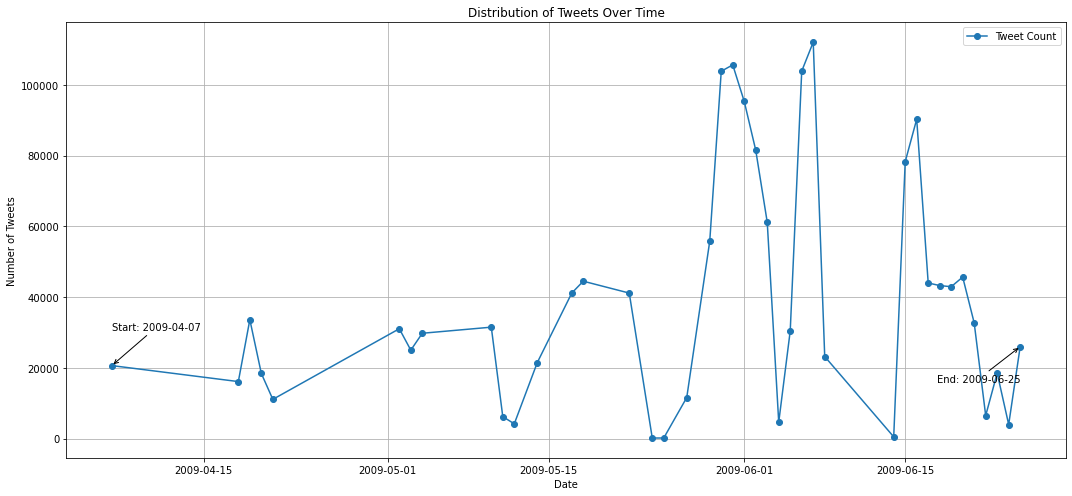

In [26]:
# Grouping tweets by date and counting the number of tweets on each date
tweets_over_time = df.withColumn("Date", to_date("Date")).groupBy("Date").agg(count("*").alias("Tweet_Count")).orderBy("Date")

# Extract the start and end dates
start_date = tweets_over_time.select(F.min("Date")).collect()[0][0]
end_date = tweets_over_time.select(F.max("Date")).collect()[0][0]

# Plotting the distribution of tweets over time
tweets_over_time_pd = tweets_over_time.toPandas()

# Convert the "Date" and "Tweet_Count" columns to NumPy arrays
dates = tweets_over_time_pd['Date'].values
tweet_counts = tweets_over_time_pd['Tweet_Count'].values

# Plotting the distribution of tweets over time
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(dates, tweet_counts, marker='o', linestyle='-', label='Tweet Count')
ax.set_title('Distribution of Tweets Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')

# Highlighting the start and end dates of the dataset
ax.annotate(f'Start: {start_date.strftime("%Y-%m-%d")}',
             xy=(start_date, tweet_counts[0]),
             xytext=(start_date, tweet_counts[0] + 10000),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='left')

ax.annotate(f'End: {end_date.strftime("%Y-%m-%d")}',
             xy=(end_date, tweet_counts[-1]),
             xytext=(end_date, tweet_counts[-1] - 10000),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='right')

# Adjusting grid, legend, and layout
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

### Insights from "Distribution of Tweets Over Time" Graph

- **Time Span Observation:**
  - The dataset spans from April 7, 2009, to June 25, 2009, encompassing nearly three months.

- **Tweet Volume Variability:**
  - There is notable fluctuation in tweet volume throughout this period, indicating variability in user engagement over time.

- **Initial Tweet Volume:**
  - The period begins with a relatively low tweet volume around April 7, 2009.

- **Notable Peaks in Activity:**
  - Mid-May marks a significant increase in tweet volume, indicating heightened user activity.
  - The peak in early June is especially pronounced, with tweet counts approaching 100,000.

- **Post-Peak Decline:**
  - Following the early June peak, there is a marked decline in tweet volume, leading to a much lower count by June 25, 2009.

- **End-of-Period Activity:**
  - A minor surge in tweet volume is observed just before the dataset concludes, suggesting a possible resurgence in interest or activity related to the tweets' topic.


In [27]:
# Replace empty strings with None (null values) in all columns
df = df.select([when(col(c) == '', None).otherwise(col(c)).alias(c) for c in df.columns])

# Count the missing values in each column
missing_values = df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])

# Display the count of missing values in each column
missing_values.show()

+---+----+----+----+--------+--------+-------+
|IDs|Date|user|text|Hashtags|Mentions|pp_text|
+---+----+----+----+--------+--------+-------+
|  0|   0|   0|   0| 1562501|  860658|   8707|
+---+----+----+----+--------+--------+-------+



### Analysis of Missing Values in Preprocessed Text

- **Significant Number of Empty Records:**
  - The `pp_text` column, which contains preprocessed text, shows 8,707 empty records. This indicates that these tweets were left with no content after the preprocessing steps, likely because they consisted solely of elements like URLs or other non-interpretable information, typical of spam tweets.

- **Action Plan:**
  - Considering the nature of these empty records, the decision has been made to drop them from the dataset. This step is crucial to ensure the integrity and relevance of the data, especially for sentiment analysis, as these records do not contribute meaningful information.


In [28]:
# Drop rows where the 'pp_text' column is null
df = df.filter(col("pp_text").isNotNull())

# Group tweets by their preprocessed text and count occurrences, then sort in descending order
tweet_distribution = df.groupBy("pp_text").count().orderBy(col("count").desc())

# Display the top 10 most common preprocessed tweet texts
tweet_distribution.show(10)

+--------------------+-----+
|             pp_text|count|
+--------------------+-----+
|              thanks| 2775|
|               thank| 1823|
|get 100 follower ...| 1484|
|        good morning| 1177|
|                miss| 1000|
|                work|  894|
|                love|  740|
|                know|  660|
|                 yes|  621|
|            headache|  565|
+--------------------+-----+
only showing top 10 rows



### Insights from Analyzing Duplicate Tweets

- **Characteristics of Duplicates:**
  - The dataset contains a mixture of frequently repeated phrases and exact duplicates of tweets. The presence of exact duplicates suggests the possibility of spam or automated content.

- **Ambiguity in Sentiment Analysis:**
  - Several common phrases like "miss," "work," and "know" are found to be prevalent but inherently sentiment-neutral. These phrases pose a challenge in sentiment analysis due to their context-dependent nature, which makes it difficult to accurately gauge the sentiment they convey.

- **Considerations for Data Cleaning:**
  - Given the substantial size of the dataset, the removal of a few thousand duplicate entries is unlikely to significantly alter the overall analytical outcome. This cleaning step is important for enhancing the quality and accuracy of the sentiment analysis, as it reduces noise and redundancy in the data.


In [29]:
# Specific tweet text used to identify spam
specific_tweet = 'get 100 follower day using add everyone train pay vip'

# Filter the DataFrame for rows matching the specific spam tweet text
filtered_df = df.filter(col("pp_text") == specific_tweet)

# Extract unique usernames associated with the spam tweet
unique_usernames = filtered_df.select("user").distinct().rdd.flatMap(lambda x: x).collect()

# Filter the main DataFrame for rows containing usernames identified as spam
spam_df = df.filter(col("user").isin(unique_usernames))

# Display the spam tweets
spam_df.show()

+-------+----------+-------------+--------------------+--------+---------------+--------------------+
|    IDs|      Date|         user|                text|Hashtags|       Mentions|             pp_text|
+-------+----------+-------------+--------------------+--------+---------------+--------------------+
|1373465|2009-06-06|tweeteradder1|@feiyie Get 100 f...|    null|         feiyie|get 100 follower ...|
|1373478|2009-06-06|tweeteradder1|@karl09 Get 100 f...|    null|         karl09|get 100 follower ...|
|1373484|2009-06-06|tweeteradder1|@bflint Get 100 f...|    null|         bflint|get 100 follower ...|
|1373491|2009-06-06|tweeteradder1|@natallon Get 100...|    null|       natallon|get 100 follower ...|
|1373501|2009-06-06|tweeteradder1|@blakmanpromo Get...|    null|   blakmanpromo|get 100 follower ...|
|1373516|2009-06-06|tweeteradder1|@savefueluk Get 1...|    null|     savefueluk|get 100 follower ...|
|1373517|2009-06-06|tweeteradder1|@mschantel_426 Ge...|    null|  mschantel_426|ge

### Removing Spam Tweets to Enhance Data Quality

- **Strategy for Identifying Spam:**
  - Spam tweets are identified using a specific repetitive text pattern, leading to the extraction of unique usernames associated with this pattern.

- **Impact on Dataset:**
  - The removal of these spam tweets is a crucial step in refining the dataset. While the removal may not significantly alter the overall results due to the dataset's size, it aids in reducing potential biases and improves the reliability of sentiment analysis.


In [30]:
# Specific text identified as spam
specific_text = "get 100 follower day using add everyone train pay vip"

# Filter the DataFrame to exclude rows with the specific spam text
df = df.filter(df["pp_text"] != specific_text)

### Implementing Sentiment Analysis

Sentiment analysis is employed to evaluate the emotional tone conveyed in tweets. It will provide insights into the general sentiment expressed by users, categorizing it as positive, neutral, or negative based on the content of each tweet.

- **Sentiment Score Calculation:**
  - A custom function is used to analyze the sentiment of each tweet, assigning a polarity score that quantifies the emotional tone.

- **Categorization of Sentiment:**
  - Based on the sentiment score, tweets are classified into 'positive', 'neutral', or 'negative' categories, offering a clear view of the overall sentiment distribution.

In [31]:
# Define UDFs for sentiment analysis
def get_sentiment_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def get_sentiment_category(score):
    if score > 0:
        return 'positive'
    elif score == 0:
        return 'neutral'
    else:
        return 'negative'

# Create UDFs for sentiment analysis
sentiment_score_udf = udf(get_sentiment_score, FloatType())
sentiment_category_udf = udf(get_sentiment_category, StringType())

# Apply UDFs to create new columns for sentiment score and category
df = df.withColumn("sentiment_score", sentiment_score_udf(df["pp_text"]))
df = df.withColumn("sentiment_category", sentiment_category_udf(df["sentiment_score"]))

# Display the DataFrame with the new sentiment analysis columns
df.show()

+---+----------+---------------+--------------------+--------+---------------+--------------------+---------------+------------------+
|IDs|      Date|           user|                text|Hashtags|       Mentions|             pp_text|sentiment_score|sentiment_category|
+---+----------+---------------+--------------------+--------+---------------+--------------------+---------------+------------------+
|  1|2009-04-07|_TheSpecialOne_|@switchfoot http:...|    null|     switchfoot|thats bummer shou...|            0.0|           neutral|
|  2|2009-04-07|  scotthamilton|is upset that he ...|    null|           null|upset cant update...|            0.0|           neutral|
|  3|2009-04-07|       mattycus|@Kenichan I dived...|    null|       Kenichan|dived many time b...|            0.5|          positive|
|  4|2009-04-07|        ElleCTF|my whole body fee...|    null|           null|whole body feel i...|            0.2|          positive|
|  5|2009-04-07|         Karoli|@nationwideclass ...|  

In [41]:
# Select desired columns for the new DataFrame
selected_columns = ["Ids", "Date", "sentiment_score", "sentiment_category"]
df2 = df.select(*selected_columns)

# Display the new DataFrame
df2.show()

+---+----------+---------------+------------------+
|Ids|      Date|sentiment_score|sentiment_category|
+---+----------+---------------+------------------+
|  1|2009-04-07|            0.0|           neutral|
|  2|2009-04-07|            0.0|           neutral|
|  3|2009-04-07|            0.5|          positive|
|  4|2009-04-07|            0.2|          positive|
|  5|2009-04-07|         -0.625|          negative|
|  6|2009-04-07|            0.2|          positive|
|  7|2009-04-07|            0.0|           neutral|
|  8|2009-04-07|     0.34166667|          positive|
|  9|2009-04-07|            0.0|           neutral|
| 10|2009-04-07|            0.0|           neutral|
| 11|2009-04-07|    -0.21428572|          negative|
| 12|2009-04-07|            0.0|           neutral|
| 13|2009-04-07|            0.0|           neutral|
| 14|2009-04-07|            0.0|           neutral|
| 15|2009-04-07|          0.225|          positive|
| 16|2009-04-07|            0.0|           neutral|
| 17|2009-04

In [42]:
# Count the number of rows in the processed dataset
dataset_size = df2.count()
print("Dataset Size:", dataset_size)

Dataset Size: 1588124


In [40]:
# Write the DataFrame to a new MySQL table
df2.write.jdbc(url=database_url, table="tweets_sentiment", mode="overwrite", properties=properties)

In [43]:
# Stop the Spark session
spark.stop()